***
### Table of Contents
1. [Introduction](#1)
2. [Modified ATE Estimation](#2)
3. [Propensity Score analysis](#3)
***

In [1]:
%load_ext autoreload
%autoreload 2
from causalnet import metrics, data_processing, model, train, viz, causal_inference_metrics
import seaborn as sns
import numpy as np
import pandas as pd
import json
import shutil
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
os.chdir("..")
np.random.seed(42)

<a id="1"></a>
### Introduction
The `causalNet` package does 2 main things to help interpret the treatment effect results:
* It estimates the expected likelihood of a sample being in the treatment group based on the variables used in your model. This estimated likelihood prediction is called the propensity score, and appears as column 'g' in our dataset.

* Secondly, the package also computes what is called a conditional prediction. Once you run both stages of the dragonnet architecture, you get 2 additional prediction columns: 'q_t0' and 'q_t1'. These are the conditional predictions, i.e what the model predicts your response to be if it were not in the treatment group (q_t0) and if it were in the treatment group (q_t1). As you can imagine, one of these will be counterfactual since no sample can be in both the groups simultaneously. To calculate the estimated treatment effect, you can just use the different in the 2 predictions. The package includes some metrics that make it easier for the user to analyse these treatment effects.

Both approaches will use the same dataset, so let's go ahead and import that now. We'll also take this opportunity to define our variables as used in the modeling process.

In [2]:
data_location = 'data/causalNet_results.csv'

categorical_variables=['Area', 'VehBrand', 'VehGas', 'Region']
continuous_variables=['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
target=['ClaimAmount']
treatment=['treatment']
weight=['weight']

np.random.seed(42)

In [3]:
df = pd.read_csv(data_location)
df.head()

,Unnamed: 0,q_t0,q_t1,g,t,weight,Area,VehBrand,VehGas,Region,y,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
0,0,38.432422,39.242215,0.332985,1,0.993812,C,B1,Regular,R82,0.000000,0.0,0.50,7.0,6.0,53.0,50.0,276.0
1,1,57.922232,52.241117,0.335028,0,0.986525,C,B1,Regular,R53,0.000000,0.0,0.16,7.0,4.0,22.0,85.0,165.0
2,2,32.854456,34.325603,0.334514,0,1.083502,B,B2,Diesel,R24,0.000000,0.0,1.00,7.0,12.0,50.0,50.0,91.0
3,3,38.609750,39.293986,0.332846,1,0.999302,D,B6,Diesel,R53,0.000000,0.0,0.75,8.0,5.0,53.0,50.0,644.0
4,4,38.380065,39.180329,0.332975,1,0.995826,C,B1,Regular,R25,1176.912502,1.0,1.00,7.0,14.0,57.0,50.0,283.0


<a id="2"></a>
### Modified Average Treatment Effect (ATE) Estimation

The method used in this section comes from a couple of different sources. The first, of course, is the source of the dragonnet methodology itself. For more information on this, please see [this](https://arxiv.org/pdf/1906.02120.pdf) paper by Shi et. al.

In addition, there are several functions included in the `causal_inference_metrics` module that were adopted by Shi et. al. from the paper "Double machine learning for treatment and causal parameters paper" [here](https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf). 

The first estimator estimates ATE using the robust treatment estimator approach as described in equation 3.9 of the `Double Machine Learning` paper linked above:

In [4]:
causal_inference_metrics.ate_aiptw(q_t0=df.q_t0, 
                     q_t1=df.q_t1, 
                     g=df.g, 
                     t=df.t, 
                     y=df.y, 
                     prob_t=sum(df.t==1)/len(df.t))

0.5260812777345787

The second estimator uses another estimation technique:

In [5]:
causal_inference_metrics.ate_psi(q_t0=df.q_t0, 
                    q_t1=df.q_t1, 
                    g=df.g, 
                    t=df.t, 
                    y=df.y, 
                    prob_t=sum(df.t==1)/len(df.t))

0.4383073848650104

Finally, there is another function that uses and provides a variety of ATE estimation techniques if user feels like comparing them. 
Depending on how large or small your data is, the volatility of these results may vary.

In [6]:
causal_inference_metrics.att_estimates(q_t0=df.q_t0, 
                         q_t1=df.q_t1, 
                         g=df.g, 
                         t=df.t, 
                         y=df.y, 
                         prob_t=sum(df.t==1)/len(df.t), 
                         truncate_level=0.05)

{'very_naive': -1.417840255184295,
 'q_only': -1.3066694872509494,
 'plugin': -1.2941413610534127,
 'one_step_tmle': (-5.634649506564362, 0.1925999999999951),
 'aiptw': -1.526118611478393}

<a id="3"></a>
### Propensity Score analysis

One of the steps that's most volatile in a causal inference modelling process is when the conditional predictions( i.e prediction of target variable given they were in any of the treatment groups) were somewhat unintuitive while the propensity scores seemed logical. So in such situations, I have found using more traditional propensity score matching technique gives you interesting results. Again, its upto the modeller to dig deep in their data to determine what is truly right or wrong. Just sharing my experience.

So `treatment_effects` function returns the propensity matched, weighted responses and weighted selection effects for the particular variable you want to analyse:

In [7]:
causal_inference_metrics.treatment_effects(df, 'Region')

,Region,y_t1,y_t0,weight_t1,weight_t0,selection
0,R11,47.492657,51.794183,1510.201051,6.601269e+05,-0.083050
1,R21,26.680850,47.370646,42.282011,2.306690e+04,-0.436764
2,R22,48.592068,44.589564,221.976765,1.637962e+05,0.089763
3,R23,21.956681,45.837075,138.756397,8.993340e+04,-0.520984
4,R24,36.435410,39.182437,6098.423703,4.146454e+06,-0.070109
5,R25,38.080248,43.399277,403.200367,3.284379e+05,-0.122560
6,R26,39.079590,40.388346,295.554532,1.865786e+05,-0.032404
7,R31,36.460422,42.822927,599.416543,4.892989e+05,-0.148577
8,R41,26.501115,43.011048,450.606704,4.657973e+05,-0.383853
9,R42,32.017281,45.608696,77.544687,4.829606e+04,-0.298001


You can also get these scores by multiple variables in your  data:

In [8]:
causal_inference_metrics.treatment_effects(df,['VehBrand', 'VehGas'], inc_raw=False)

,VehBrand,VehGas,selection
0,B1,Diesel,0.019833
1,B1,Regular,-0.037261
2,B10,Diesel,0.048505
3,B10,Regular,0.089017
4,B11,Diesel,-0.063163
5,B11,Regular,0.018617
6,B12,Diesel,-0.126218
7,B12,Regular,-0.366313
8,B13,Diesel,0.504115
9,B13,Regular,-0.024158


You can also adjust how granular of a propensity score matching the process should use. You should aim for a balance between granularity and meaningful volumes in each sub-category

In [9]:
causal_inference_metrics.treatment_effects(df, 'VehGas',cut_size=5000)

,VehGas,y_t1,y_t0,weight_t1,weight_t0,selection
0,Diesel,41.020643,40.543072,9407.232278,1.436904e+06,0.011779
1,Regular,40.887959,42.191162,10693.897565,1.595508e+06,-0.030888


These tables can be useful when you might want to visualize the selection effect across different groups. 
Below is an example of how treatment effects vary by `VehicleGas`and how its selection effect might differ for 2 different cohorts of `Region` (Region AB & Region CDEF):

In [10]:
def region(df):
    if df['Area'] in ['A','B']:
        return 'Region AB'
    else:
        return 'Region CDEF'

In [11]:
df['regionSubGroup'] = df.apply(region, axis=1)

In [12]:
causal_inference_metrics.treatment_effects(df,['regionSubGroup','VehGas'])

,regionSubGroup,VehGas,y_t1,y_t0,weight_t1,weight_t0,selection
0,Region AB,Diesel,30.989766,38.692350,3262.490603,1.906217e+06,-0.199073
1,Region AB,Regular,34.030375,38.454308,2654.390376,1.509717e+06,-0.115044
2,Region CDEF,Diesel,46.346440,41.795587,6144.741675,4.835981e+06,0.108884
3,Region CDEF,Regular,43.152116,44.974310,8039.507190,5.947770e+06,-0.040516


<AxesSubplot:xlabel='VehGas', ylabel='selection'>

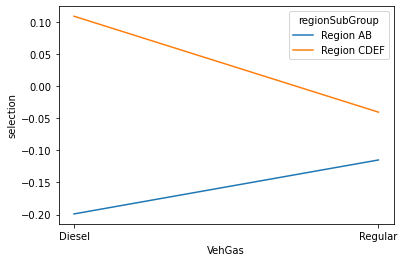

In [13]:
chart_frame = causal_inference_metrics.treatment_effects(df,['regionSubGroup','VehGas'], inc_raw=False)
sns.lineplot(data=chart_frame,
             x = 'VehGas',
             y = 'selection',
             hue = 'regionSubGroup')